In [8]:
from sklearn.datasets import *
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
%matplotlib inline

def plot_2Ddata_with_boundary(predict,X,y):
    n = 200
    mins,maxs = np.min(d,axis=0), np.max(d,axis=0)
    mins -= np.abs(mins)*.2
    maxs += np.abs(maxs)*.2
    d0 = np.linspace(mins[0], maxs[0],n)
    d1 = np.linspace(mins[1], maxs[1],n)
    gd0,gd1 = np.meshgrid(d0,d1)
    D = np.hstack((gd0.reshape(-1,1), gd1.reshape(-1,1)))
    p = (predict(D)*1.).reshape((n,n))
    plt.contourf(gd0,gd1,p, levels=[-0.1,0.5], alpha=0.5, cmap=plt.cm.Greys)
    plt.scatter(X[y==0][:,0], X[y==0][:,1], c="blue")
    plt.scatter(X[y==1][:,0], X[y==1][:,1], c="red")

Podríamos poner simplemente un umbral a una regresión lineal para convertirlo en un problema de clasificación, pero:

- tendríamos una función discontinua, lo que complica derivadas, etc.
- el problema de clasificación es fundamentalmente distinto y es fácil encontrar casos con comportamientos no deseados

usamos por tanto la función sigmoide $g(x) = \frac{1}{1+e^x}$, garantizando que $g(x) \in [0,1]$ y ponemos un umbral en 0.5

usaremos un dataset sintético de `sklearn`

In [9]:
from sklearn.linear_model import LogisticRegression
n=200
(d,c) = make_moons(n_samples=n, noise=0.2)

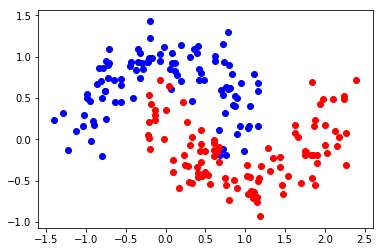

In [10]:
plt.scatter(d[c==0][:,0], d[c==0][:,1], c="blue")
plt.scatter(d[c==1][:,0], d[c==1][:,1], c="red")

### Aproximación basada en coste

denotamos un punto cualquiera en $\mathbb{R}^2$ por $\mathbf{x}= [1, x_1^{(i)}, x_2^{(i)}]$ (observa que le hemos añadido un 1), y está asociado a una clase $y^{(i)} \in \{0,1\}$.

**ASUMIMOS** que las clases son linealmente separables por una hiperplano parametrizado por $\theta = [\theta_0, \theta_1, \theta_2]$ a través de la siguiente función:

$$\hat{y}^{(i)} = g(\mathbf{x}^{(i)}\theta)\;\;\;\; \hat{y}^{(i)} \in [0,1]$$

con $g(z) = \frac{1}{1+e^{-z}}$, la función sigmoide. Si $\hat{y}^{(i)}<0.5$ consideramos que la estimación clasifica el dato $x^{(i)}$ en la clase 0, y si no en la clase 1. Observa que $g$ es una función escalar: $g: \mathbb{R} \rightarrow \mathbb{R}$

queremos encontrar los valores $\theta_{min}$ que parametrizan un hiperplano  de modo que


$$\theta_{min} = \underset{\theta}{arg\,min} \,\,\,\frac{1}{m}\sum_{i=0}^{m-1} (y^{(i)}-g(\theta\mathbf{x}^{(i)}))^2$$ 

Usamos `sympy` para definir la expresión de coste, obtener las derivadas y las funciones evaluables python para usar el minimizador. Observa como, primero, añadimos una columna de unos a $X$

In [11]:
X = np.hstack((np.ones((len(d),1)), d))
y = c

import sympy
t0,t1, t2 = sympy.symbols("theta_0 theta_1 theta_2")
x0,x1, x2 = sympy.symbols("x_0 x_1 x_2")
expr = 0
for i in range(len(X)):
    expr += ( 1/(1+sympy.exp(-(X[i,0]*t0+X[i,1]*t1+X[i,2]*t2)))  - y[i])**2
expr_cost = expr/len(X)
expr_dt0 = expr.diff(t0)
expr_dt1 = expr.diff(t1)
expr_dt2 = expr.diff(t2)

In [12]:
s_cost = sympy.lambdify([[t0,t1,t2]], expr_cost, "numpy")

d0 = sympy.lambdify([[t0,t1,t2]], expr_dt0, "numpy")
d1 = sympy.lambdify([[t0,t1,t2]], expr_dt1, "numpy")
d2 = sympy.lambdify([[t0,t1,t2]], expr_dt2, "numpy")

s_grad = lambda x: np.array([d0(x), d1(x), d2(x)])

In [13]:
sr = minimize(s_cost, np.zeros(X.shape[1]), jac=s_grad, method="BFGS")
print sr

      fun: 0.09108884637586098
 hess_inv: array([[ 0.10829876,  0.00738862, -0.25319814],
       [ 0.00738862,  0.13616044, -0.30749238],
       [-0.25319814, -0.30749238,  1.58425416]])
      jac: array([ 6.91200159e-07, -7.38510276e-06,  8.44832725e-06])
  message: 'Optimization terminated successfully.'
     nfev: 267
      nit: 69
     njev: 267
   status: 0
  success: True
        x: array([ 0.43803806,  1.09713358, -3.92160477])


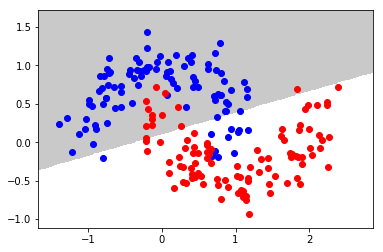

In [14]:
def predict(X, theta):
    X = np.hstack((np.ones((len(X),1)), X))
    return (1/(1+np.exp(X.dot(theta)))<0.5)*1
plot_2Ddata_with_boundary(lambda x: predict(x, sr.x), d, y)

### Aproximación probabilística

**INTERPRETAMOS** la función $g(\mathbf{x}\theta)$ como la probabilidad de que el elemento $\mathbf{x}$ pertenezca a la clase 1.

Es decir:

- $P(y=1|\mathbf{x};\theta) = g(\mathbf{x}\theta)$
- $P(y=0|\mathbf{x};\theta) = 1-g(\mathbf{x}\theta)$

o de modo más compacto:

$$P(y|\mathbf{x};\theta) = (g(\mathbf{x}\theta))^y(1-g(\mathbf{x}\theta))^{1-y}$$

así, la probabilidad de ver los datos que tengo:

$$L(\theta) = \prod_{i=0}^{m-1}P(y_i|\mathbf{x}_i;\theta) = $$

$$ = \prod_{i=0}^{m-1}(g(\mathbf{x}_i\theta))^{y_i}(1-g(\mathbf{x}_i\theta))^{1-y_i} $$

esto es el **estimador de máxima verosimilitud** (_maximum likelihood estimator_ o **MLE**), el cual queremos **MAXIMIZAR**

y es más fácil maximizar el logaritmo:

$$l(\theta) = \sum_{i=0}^{m-1}y_i log(g(\mathbf{x}_i\theta))+(1-y_i) log(1-g(\mathbf{x}_i\theta))$$


cuyo gradiente en forma matricial viene dado por:

$$\nabla J= \frac{1}{m}2X^{T}\cdot(Y-g(X\cdot\theta))$$


Fíjate cómo resolvemos este problema de optimización con `sklearn.optimize`. Como queremos **MAXIMIZAR**, tenemos que cambiarle el signo tanto al coste como al gradiente.

In [15]:
def g(X):
    return 1/(1+np.exp(-X))
def grad(t):
    return -2*X.T.dot(y-g(X.dot(t)))/len(X)
def cost(t):
    return -np.sum(np.log(g(X.dot(t)))*y+np.log(1-g(X.dot(t)))*(1-y))

      fun: 57.966497668326895
 hess_inv: array([[ 9.81608141, -3.61525905, -9.35384603],
       [-3.61525905,  7.31706175, -1.48829636],
       [-9.35384603, -1.48829636, 42.40526632]])
      jac: array([ 9.25678102e-07,  1.09636312e-06, -1.21371387e-07])
  message: 'Optimization terminated successfully.'
     nfev: 18
      nit: 17
     njev: 18
   status: 0
  success: True
        x: array([ 0.4973242 ,  1.22534872, -4.44127754])
predictions    [0 0 0 0 1 1 0 1 0 0 1 1 0 0 1 1 0 0 1 1 1 1 1 1 0 0 1 1 0 0 0 1 1 0 1 0 0
 1 0 0 1 1 1 1 0 1 1 1 0 0 0 0 0 0 1 0 1 0 1 1 0 0 1 1 0 0 0 0 1 1 0 0 1 1
 1 0 0 1 0 0 1 0 1 0 0 1 0 1 0 1 1 0 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 0 0 1 0
 0 0 1 1 1 1 1 1 0 1 0 1 0 0 1 0 0 0 0 0 0 1 0 1 0 0 1 0 0 0 0 1 1 0 1 0 1
 0 0 0 1 0 1 1 0 1 0 0 1 0 0 0 1 1 0 1 1 1 0 1 1 0 0 0 0 1 1 1 0 0 0 1 0 1
 1 0 1 0 1 1 1 0 1 1 1 0 0 0 0]
actual classes [0 0 0 0 1 1 0 1 0 0 1 1 0 1 0 1 0 1 1 0 1 0 1 1 0 0 1 1 0 0 0 1 1 0 1 0 0
 1 0 0 1 1 1 1 0 0 1 1 0 0 0 1 0 0 1 1 1 0 1 1 0 0 1

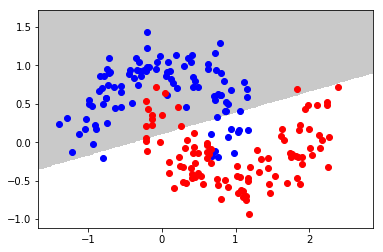

In [16]:
r = minimize(cost, np.zeros(X.shape[1]), jac=grad, method="BFGS")
print r
print "predictions   ", predict(d, r.x)
print "actual classes", c

plot_2Ddata_with_boundary(lambda x: predict(x, r.x), d, y)

Aunque los parámetros obtenidos no son exactamente los mismos

In [17]:
sr.x, r.x

(array([ 0.43803806,  1.09713358, -3.92160477]),
 array([ 0.4973242 ,  1.22534872, -4.44127754]))